## Set Up

In [29]:
import torch
import os
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import sys

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)

print("Torch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
device

ModuleNotFoundError: No module named 'data_d'

In [34]:
current_dir = os.path.abspath(os.getcwd())
data_dir = os.path.join(current_dir, "dataset/1/HMU-GC-HE-30K/all_image")
data_dir = os.path.abspath(data_dir) 

transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(), #turns image into numpy array
    transforms.Normalize(mean = [0.5,0.5,0.5], std = [0.5,0.5,0.5])
])

loaded_data = datasets.ImageFolder(root = data_dir, transform = transform)

train_size = int(0.8 * len(loaded_data))
val_train = len(loaded_data)-train_size
half_train = int(0.5*val_train)

train_dataset, temp_dataset = random_split(loaded_data, [train_size, val_train])
val_dataset, test_dataset = random_split(temp_dataset, [half_train,half_train])

len(train_dataset), len(val_dataset), len(test_dataset)


(24876, 3110, 3110)

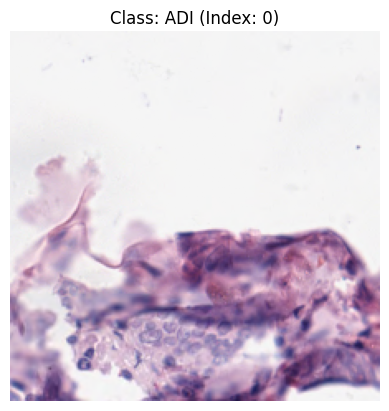

torch.Size([3, 224, 224])


In [8]:
image_tensor, label_index = loaded_data[0]
image_np = image_tensor.permute(1,2,0).numpy() # C, H, W -> H, W, C
image_np = (image_np+1)/2
class_name = loaded_data.classes[0]
plt.imshow(image_np)
plt.title(f"Class: {class_name} (Index: {0})")
plt.axis('off')
plt.show()
print(image_tensor.shape)

In [9]:
train_loader = DataLoader(dataset = train_dataset, shuffle = True, batch_size = 128)
val_loader = DataLoader(dataset = val_dataset, shuffle = False, batch_size = 32)
test_loader = DataLoader(dataset = test_dataset, shuffle = False, batch_size = 32)
len(train_loader), len(val_loader), len(test_loader)


(195, 98, 98)

In [10]:
import torch
import torch.nn as nn

class H_CNN(nn.Module):
    def __init__(self, in_channels=3, num_classes = 8):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels, 12, kernel_size = 3) ##224-2 = 222/2 = 111
        self.relu1 = nn.ReLU()
        self.maxP1 = nn.MaxPool2d(2) #takes the max and discards the rest

        self.conv2 = nn.Conv2d(12, 24, kernel_size = 3) ## 111-2 = 109/2= 54
        self.relu2 = nn.ReLU()
        self.maxP2 = nn.MaxPool2d(2)

        self.conv3 = nn.Conv2d(24, 64, kernel_size = 3) ## 54 - 2 = 52 / 2 = 26
        self.relu3 = nn.ReLU()
        self.maxP3 = nn.MaxPool2d(2)

        self.flatten = nn.Flatten()
        self.linear = nn.Linear(43264, num_classes)

    def forward(self, x): #receives X, put through convolution first, self.conv1(x)
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxP1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxP2(x)
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.maxP3(x)
        x = self.flatten(x)
        out = self.linear(x)
        return out
        

In [11]:
def accuracy(logits, targets):
    preds = logits.argmax(dim=1)
    # (preds == targets) → boolean tensor showing which predictions are correct
    # .float() → convert True/False to 1.0/0.0
    # .mean() → average across the batch = fraction correct
    # .item() → convert scalar tensor to regular Python float
    return (preds == targets).float().mean().item()
    
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0
    total_acc = 0
    n_batches = 0
    for x,y in loader:
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_acc += accuracy(logits.detach(), y)
        n_batches += 1
    return total_loss/n_batches, total_acc/n_batches
def evaluate(model, loader, criterion):
    model.eval()
    total_loss = 0
    total_acc = 0
    n_batches = 0
    with torch.no_grad():
        for x,y in loader:
            x = x.to(device)
            y = y.to(device)
            logits = model(x)
            loss = criterion(logits, y)
            total_loss += loss.item()
            total_acc += accuracy(logits, y)
            n_batches += 1
    return total_loss/n_batches,total_acc/n_batches


In [8]:
ffd = []
for i, (data, labels) in enumerate(train_loader):
    if i >= 20:
        break
    ffd.append((data, labels))

ffv = []
for i, (data, labels) in enumerate(val_loader):
    if i >= 5:
        break
    ffv.append((data, labels))

In [23]:
import pandas as pd
model = H_CNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001) #if val acc is greater than train then its overfitting a bit, needs regularization

EPOCHS = 10
results = []
for epoch in range(1, EPOCHS + 1):
    tl, ta = train_one_epoch(model, train_loader, optimizer, criterion)
    vl, va = evaluate(model, test_loader, criterion)

    results.append({
        'epoch': epoch,
        'train_loss': tl,
        'train_acc': ta,
        'val_loss': vl,
        'val_acc': va
    })

    print(f"Epoch {epoch:02d} | "
          f"train_loss={tl:.4f} val_loss={vl:.4f} "
          f"train_acc={ta:.4f} val_acc={va:.4f}")
    if epoch%5 == 0:
        torch.save(model.state_dict(), 'Final_Project_Weights')

# Convert to DataFrame for analysis
history_cnn = pd.DataFrame(results)



Epoch 01 | train_loss=1.5897 val_loss=1.4825 train_acc=0.3734 val_acc=0.4106
Epoch 02 | train_loss=1.3981 val_loss=1.4061 train_acc=0.4588 val_acc=0.4465
Epoch 03 | train_loss=1.3462 val_loss=1.3879 train_acc=0.4773 val_acc=0.4622
Epoch 04 | train_loss=1.3221 val_loss=1.3736 train_acc=0.4887 val_acc=0.4599
Epoch 05 | train_loss=1.2935 val_loss=1.3646 train_acc=0.5031 val_acc=0.4666
Epoch 06 | train_loss=1.2701 val_loss=1.3577 train_acc=0.5133 val_acc=0.4740
Epoch 07 | train_loss=1.2514 val_loss=1.3523 train_acc=0.5242 val_acc=0.4759
Epoch 08 | train_loss=1.2275 val_loss=1.3635 train_acc=0.5340 val_acc=0.4727
Epoch 09 | train_loss=1.2086 val_loss=1.3394 train_acc=0.5433 val_acc=0.4797
Epoch 10 | train_loss=1.1799 val_loss=1.3398 train_acc=0.5570 val_acc=0.4794


In [19]:
model = H_CNN()
model.load_state_dict(torch.load('Final_Project_Weights'))

<All keys matched successfully>